# Задание 3

In [ ]:
!pip install -q catalyst

     |████████████████████████████████| 543 kB 7.3 MB/s 
     |████████████████████████████████| 636 kB 16.6 MB/s 
     |████████████████████████████████| 120 kB 29.5 MB/s 


In [89]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [90]:
torch.zeros((5))

tensor([0., 0., 0., 0., 0.])

In [91]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        print(self.weights.shape)
        if bias:
            self.bias_term = torch.zeros(out_features, requires_grad=True)# YOUR CODE GOES HERE

    def forward(self, x):
        
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [92]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [93]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [95]:
X_train_t = torch.from_numpy(X_train) # YOUR CODE GOES HERE
y_train_t =  torch.from_numpy(y_train)# YOUR CODE GOES HERE
X_val_t =  torch.from_numpy(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.from_numpy(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [96]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [97]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

torch.Size([2, 1])


**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [98]:
y_train_t.shape

torch.Size([7500])

In [99]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch.float()) # YOUR CODE GOES HERE
        y_batch = y_batch.view((y_batch.shape[0], 1))
        loss =  loss_function(outp, y_batch.float()) # YOUR CODE GOES HERE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True) # YOUR CODE GOES HERE
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.0
Iteration: 7500
Batch accuracy: 62.0
Iteration: 15000
Batch accuracy: 62.0
Iteration: 22500
Batch accuracy: 62.0
Iteration: 30000
Batch accuracy: 62.0
Iteration: 37500
Batch accuracy: 62.0
Iteration: 45000
Batch accuracy: 62.0
Iteration: 52500
Batch accuracy: 62.0
Iteration: 60000
Batch accuracy: 62.0
Iteration: 67500
Batch accuracy: 62.0
Iteration: 75000
Batch accuracy: 62.0
Iteration: 82500
Batch accuracy: 62.0
Iteration: 90000
Batch accuracy: 62.0

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 90047

### Визуализируем результаты

In [100]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [101]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [105]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch.float())
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [106]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
# YOUR CODE GOES HERE

In [108]:
accuracy_score(y_val_t, predictions)

0.8688

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

### MNIST

In [111]:
import os
from catalyst.contrib.datasets import MNIST

batch_size = 128

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE

In [112]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [143]:
activation = nn.LeakyReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [129]:
torch.tensor(10)

tensor(10)

In [146]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE GOES HERE
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.float())
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                 # YOUR CODE GOES HERE
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.float())
            preds = outp.argmax(-1)
            correct = torch.tensor(len([preds[i] for i in range(len(preds)) if preds[i]== y_batch[i]])) # YOUR CODE GOES HERE
            all = torch.tensor(len(y_batch)) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                 # YOUR CODE GOES HERE
                 # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9001569747924805
Loader: valid. Accuracy: 0.9061498641967773
Epoch: 2
Loader: train. Accuracy: 0.9553285837173462
Loader: valid. Accuracy: 0.9546130895614624
Epoch: 3
Loader: train. Accuracy: 0.9663628935813904
Loader: valid. Accuracy: 0.9641426205635071
Epoch: 4
Loader: train. Accuracy: 0.9706864953041077
Loader: valid. Accuracy: 0.9693223237991333
Epoch: 5
Loader: train. Accuracy: 0.9742254614830017
Loader: valid. Accuracy: 0.9715831279754639
Epoch: 6
Loader: train. Accuracy: 0.9762954711914062
Loader: valid. Accuracy: 0.9747167229652405
Epoch: 7
Loader: train. Accuracy: 0.9789831042289734
Loader: valid. Accuracy: 0.9767342209815979
Epoch: 8
Loader: train. Accuracy: 0.9777477979660034
Loader: valid. Accuracy: 0.9756324291229248
Epoch: 9
Loader: train. Accuracy: 0.9787994623184204
Loader: valid. Accuracy: 0.976219117641449
Epoch: 10
Loader: train. Accuracy: 0.9817875623703003
Loader: valid. Accuracy: 0.97940993309021


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [137]:
plain_accuracy = accuracy["valid"]

In [142]:
relu_accuracy = accuracy["valid"]

In [147]:
leaky_relu_accuracy = accuracy["valid"]

In [132]:
elu_accuracy = accuracy["valid"]

### Accuracy

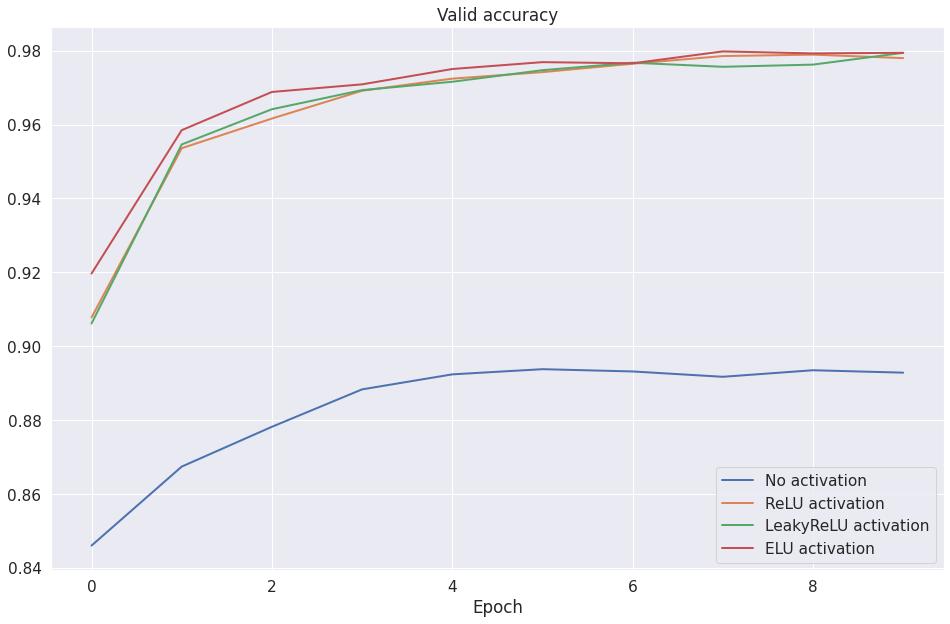

In [151]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

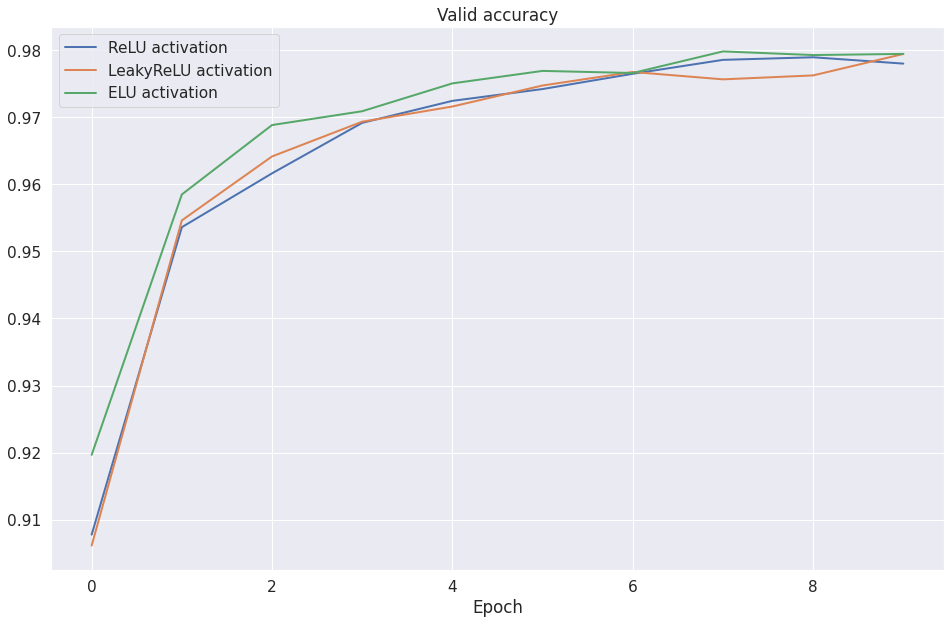

In [152]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** ELU / Relu

## Сверточные слои

### Ядра

In [153]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-08-03 12:08:17--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-08-03 12:08:18--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   162KB/s    in 0.3s    

2021-08-03 12:08:19 (162 KB/s) - ‘sample_photo.jpg’ saved [49337/4

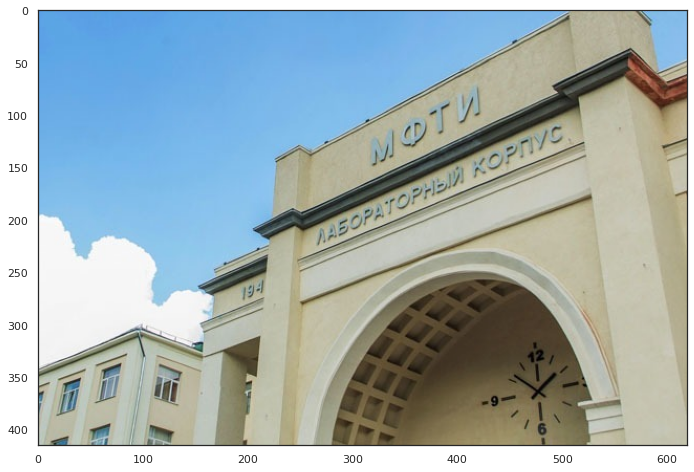

In [154]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [165]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [166]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}



*   Новый пункт
*   Новый пункт



In [169]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE GOES HERE
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch[:, np.newaxis].type(torch.float32))
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.type(torch.float32).unsqueeze(1))
            preds = outp.argmax(-1)
            correct = torch.tensor(len([preds[i] for i in range(len(preds)) if preds[i]== y_batch[i]])) # YOUR CODE GOES HERE
            all = torch.tensor(len(y_batch)) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                 # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
Loader: train. Accuracy: 0.9382011890411377
Loader: valid. Accuracy: 0.9432663917541504
Epoch: 2
Loader: train. Accuracy: 0.9804854989051819
Loader: valid. Accuracy: 0.9803256392478943
Epoch: 3
Loader: train. Accuracy: 0.9860610961914062
Loader: valid. Accuracy: 0.9858344793319702
Epoch: 4
Loader: train. Accuracy: 0.9888989329338074
Loader: valid. Accuracy: 0.9882383346557617
Epoch: 5
Loader: train. Accuracy: 0.9901175498962402
Loader: valid. Accuracy: 0.989325761795044
Epoch: 6
Loader: train. Accuracy: 0.9918035864830017
Loader: valid. Accuracy: 0.9911143779754639
Epoch: 7
Loader: train. Accuracy: 0.9929053783416748
Loader: valid. Accuracy: 0.9913433194160461
Epoch: 8
Loader: train. Accuracy: 0.9936231970787048
Loader: valid. Accuracy: 0.9924307465553284
Epoch: 9
Loader: train. Accuracy: 0.9939737319946289
Loader: valid. Accuracy: 0.992902934551239
Epoch: 10
Loader: train. Accuracy: 0.9937900900840759
Loader: valid. Accuracy: 0.9925881624221802


In [170]:
lenet_accuracy = accuracy["valid"]

In [172]:
lenet_accuracy

[tensor(0.9433),
 tensor(0.9803),
 tensor(0.9858),
 tensor(0.9882),
 tensor(0.9893),
 tensor(0.9911),
 tensor(0.9913),
 tensor(0.9924),
 tensor(0.9929),
 tensor(0.9926)]

Сравним с предыдущем пунктом

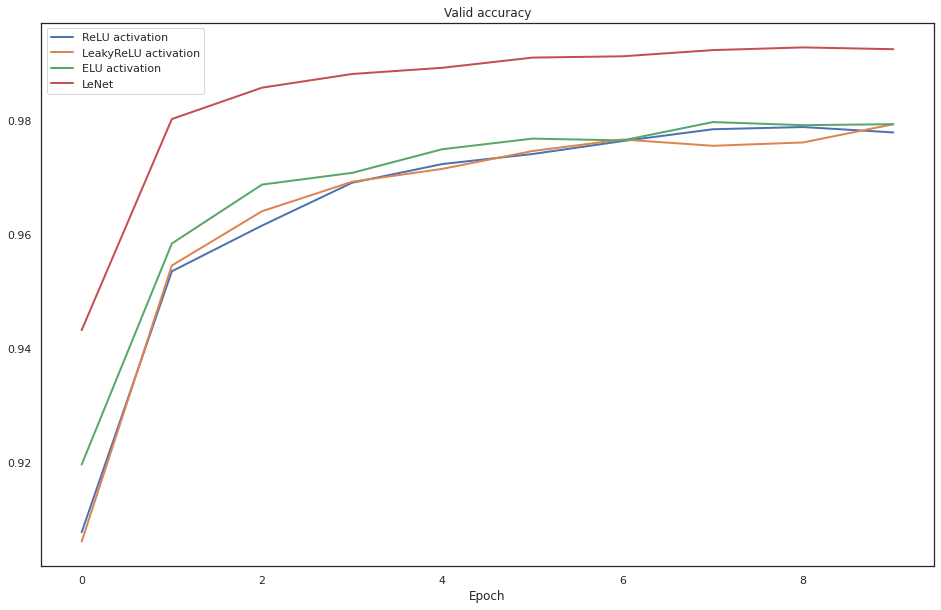

In [171]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**